# Inżynieria Uczenia Maszynowego

Studenci:
```
Bartłomiej Krawczyk
Mateusz Brzozowski
```

## Temat

> “Jakiś czas temu wprowadziliśmy konta premium, które uwalniają użytkowników od słuchania reklam. Nie są one jednak jeszcze zbyt popularne – czy możemy się dowiedzieć, które osoby są bardziej skłonne do zakupu takiego konta?”

In [1]:
import itertools
import numpy as np
import pandas as pd
import pickle
import requests

from IPython.display import display
from math import sqrt
from scipy.stats import uniform
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statistics import stdev, mean
from typing import Any, Dict, Optional
from xgboost import XGBClassifier

from microservice import IUMModel
from utility import (
    plot_matrix,
    construct_dummy,
    construct_logistic_reggression,
    plot_confusion_matrix,
    plot_feature_importances,
    get_params,
    Model,
    FEATURES,
    TARGETS,
    TARGET_AND_FEATURES,
    DUMMY,
    LOGISTIC_REG,
    XGB,
    XGB_BEST_ESTIMATOR,
    MODEL_TYPES,
    SERVICE_PREDICTION_MODEL_INIT
)

## Cechy i funkcje celu

Do trenowania naszych modeli przygotowaliśmy następujące cechy wygenerowane na podstawie dostarczonych danych:
- `number_of_advertisements`, ilość odtworzonych reklam w danym miesiącu
- `number_of_tracks`, ilość przesłuchanych utworów w danym miesiącu
- `number_of_skips`, ilość pominiętych utworów w danym miesiącu
- `number_of_likes`, liczba danych lików w danym miesiącu
- `number_of_liked_tracks_listened`, liczba przesłuchanych utworów w danym miesiącu, które w momencie odtworzenia były polubione
- `number_of_tracks_in_favourite_genre`, liczba przesłuchanych utworów z ulubionego gatunku w danym miesiącu
- `total_number_of_favourite_genres_listened`, liczba przesłuchanych gatunków w danym miesiącu należących do ulubionych użytkownika
- `average_popularity_in_favourite_genres`, średnia popularność utworów wśród ulubionych gatunków w danym miesiącu
- `total_tracks_duration_ms`, całkowity czas przesłuchanych utworów w danym miesiącu
- `number_of_different_artists`, ilość przesłuchanych artystów w danym miesiącu
- `average_release_date`, średnia data przesłuchanych piosenek w danym miesiącu
- `average_duration_ms`, średni czas trwania utworów przesłuchanych w danym miesiącu
- `explicit_tracks_ratio`, ułamek "wulgarnych" utworów przesłuchanych w danym miesiącu
- `average_popularity`, średnia popularność przesłuchanych utworów w danym miesiącu
- `average_acousticness`, średnia akustyka przesłuchanych utworów w danym miesiącu
- `average_danceability`, średnia taneczność przesłuchanych utworów w danym miesiącu
- `average_energy`, średnia moc przesłuchanych utworów w danym miesiącu
- `average_instrumentalness`, średnia ilość utworów z wokalem przesłuchanych w danym miesiącu
- `average_liveness`, średnie brzmienie utworów na żywo przesłuchanych w danym miesiącu
- `average_loudness`, średnia głośność przesłuchanych utworów w danym miesiącu
- `average_speechiness`, średnia ilość wokalu w utworach przesłuchanych w danym miesiącu
- `average_tempo`, średnia prędkość przesłuchanych utworów w danym miesiącu
- `average_valence`, średnia emocjonalność przesłuchanych utworów w danym miesiącu
- `average_track_name_length`, średnia długość nazwy utworów przesłuchanych w danym miesiącu
- `average_daily_cost`, średni koszt utrzymania przesłuchanych piosenek w danym miesiącu

Posiadamy również dwie funkcje celu:
- `premium_user_numerical`, która określa czy użytkownik kiedykolwiek kupi premium
- `will_buy_premium_next_month_numerical` przedstawiająca to czy użytkownik zakupi premium w przeciągu następnych 30 dni


In [2]:
FEATURE_VERSION = 'v1'
FEATURE_PATH = f'features/{FEATURE_VERSION}/feature.csv'

In [3]:
data_frame = pd.read_csv(FEATURE_PATH)

### Przykładowe wartości cech oraz funkcji celu

In [4]:
data_frame.head()

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,212,2020,2,1,0,0,10,30,16,8,...,0.542767,0.600467,0.094653,0.179113,-10.158167,0.049070,121.964467,0.588167,22.233333,0.012134
1,212,2020,7,1,0,0,5,16,8,2,...,0.499000,0.675250,0.150966,0.226225,-8.795062,0.061812,123.069063,0.452131,22.687500,0.014780
2,212,2020,1,1,0,0,14,39,21,12,...,0.487000,0.691667,0.119363,0.235690,-9.491795,0.064918,123.745769,0.564369,19.461538,0.012399
3,212,2020,3,1,0,0,3,20,9,6,...,0.516700,0.637150,0.069641,0.189545,-8.409150,0.053715,121.415600,0.586000,21.250000,0.012706
4,212,2020,8,1,0,0,13,40,22,12,...,0.513525,0.642350,0.112645,0.285203,-9.562400,0.055282,120.922325,0.510517,24.000000,0.013076


### Macierz korelacji cech z wartościami przewidywanymi
Sprawdzamy korelację cech, które nie są zbytnio skorelowane między sobą, a za to są skorelowane z targetem.

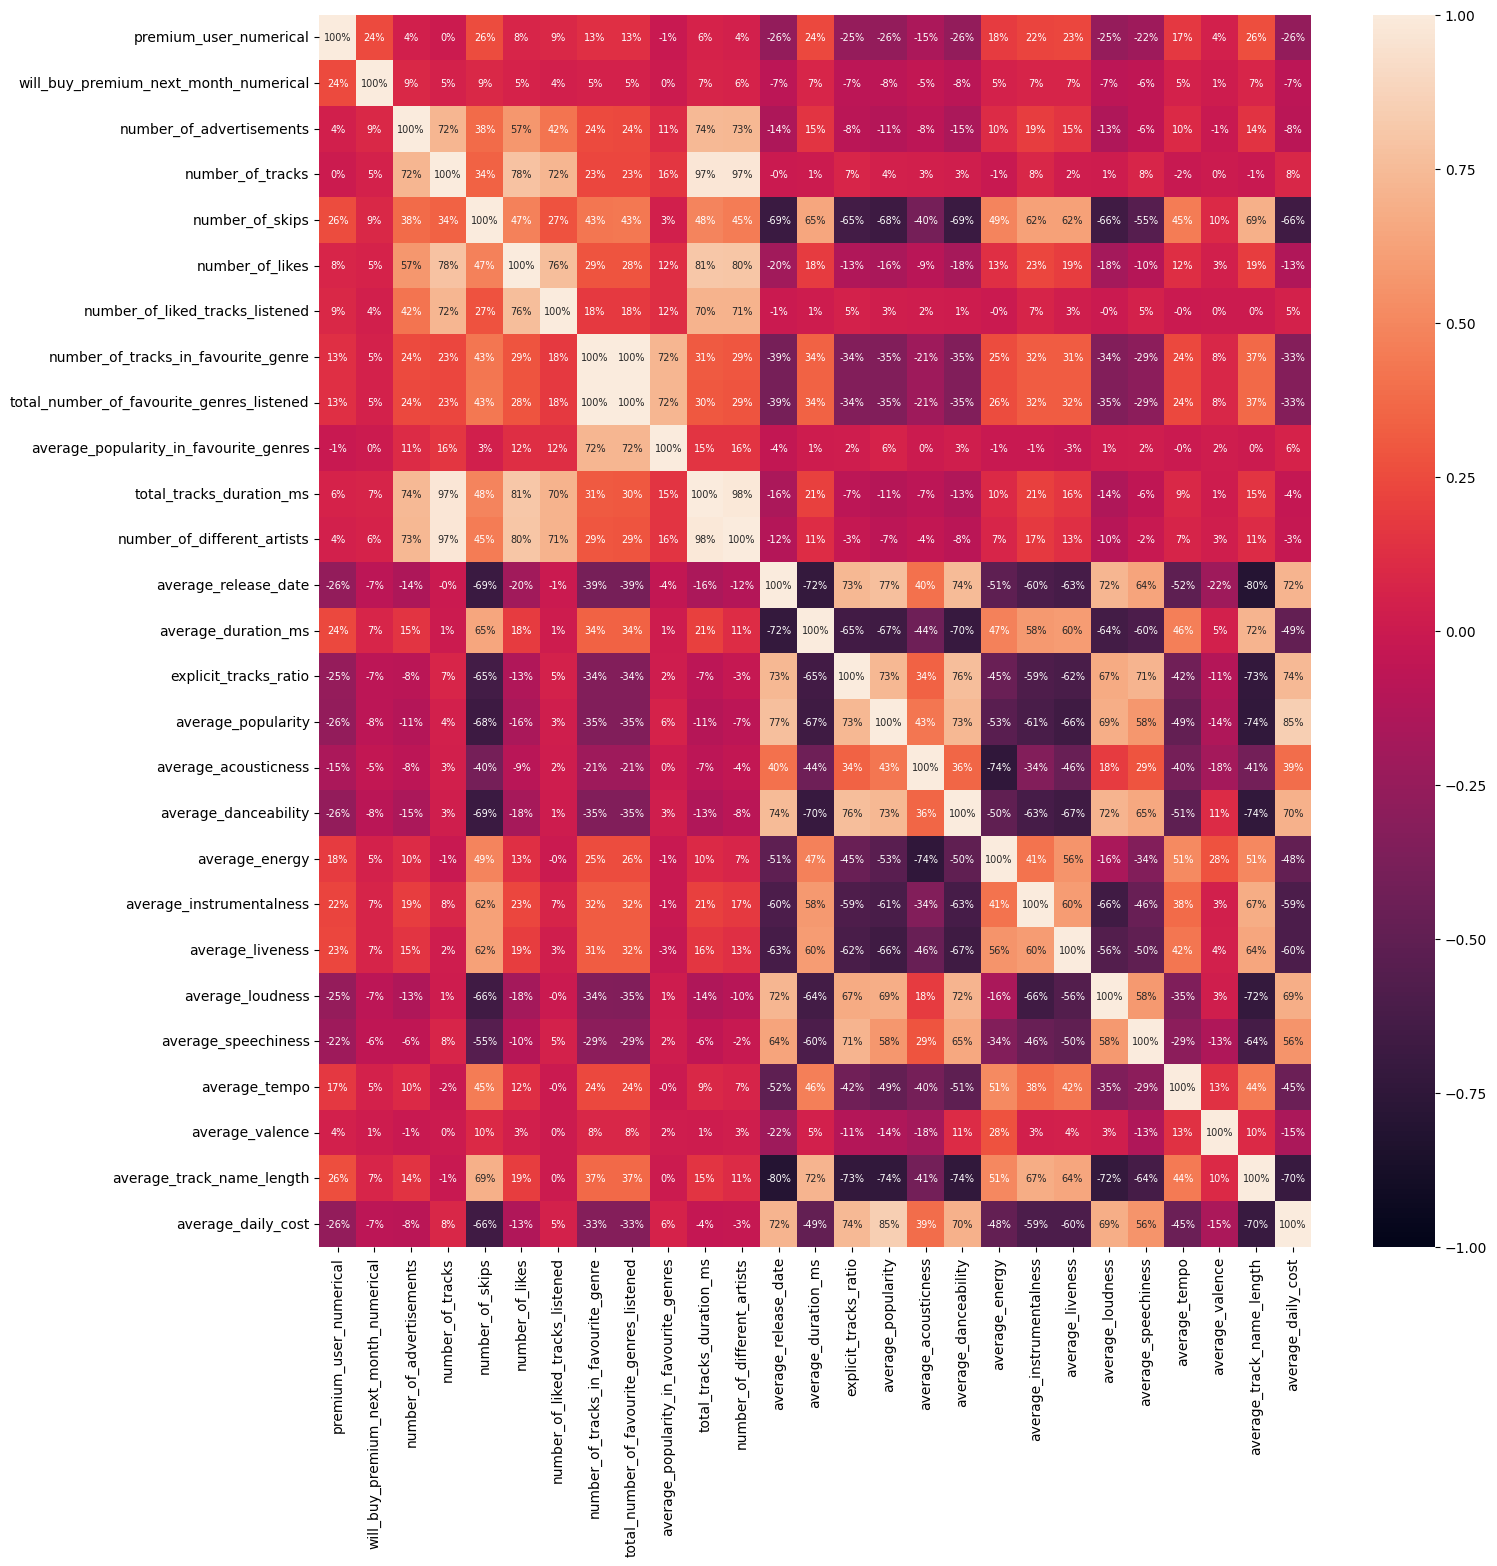

In [5]:
correlation_matrix = data_frame.loc[:, TARGET_AND_FEATURES] \
    .corr(method='spearman')

plot_matrix(correlation_matrix)

In [6]:
RANDOM_SEED: int = 48548579
np.random.seed(RANDOM_SEED)

Definiujemy pipeline do uzupełnienia danych pustych oraz przeskalowania danych

In [7]:
pipeline = Pipeline([
    ("simple_imputer", SimpleImputer()),
    ("standard_scaler", StandardScaler())
])

Dzielimy dane na dane trenujące oraz testowe do późniejszych eksperymentów A/B

In [8]:
TRAINING_UP_TO = 2023
TRAIN_DATA: pd.DataFrame = data_frame.loc[data_frame.year < TRAINING_UP_TO, :]
TEST_DATA: pd.DataFrame = data_frame.loc[data_frame.year >= TRAINING_UP_TO, :]
TEST_SIZE = 0.33

Pipeline uczony jest na podstawie samych danych testowych


In [9]:
X_train_temp, X_test_temp, Y_train, Y_test = train_test_split(
    TRAIN_DATA[FEATURES],
    TRAIN_DATA[TARGETS],
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)
X_train_temp: pd.DataFrame
X_test_temp: pd.DataFrame
Y_train: pd.DataFrame
Y_test: pd.DataFrame

train_data = pipeline.fit_transform(X_train_temp)
test_data = pipeline.transform(X_test_temp)
X_train = pd.DataFrame(train_data, columns=FEATURES)
X_test = pd.DataFrame(test_data, columns=FEATURES)

### Cechy przetworzone przez pipeline

In [10]:
X_train.head()

,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,number_of_liked_tracks_listened,number_of_tracks_in_favourite_genre,total_number_of_favourite_genres_listened,average_popularity_in_favourite_genres,total_tracks_duration_ms,number_of_different_artists,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
0,0.633306,1.171994,-0.711336,0.021750,0.852902,-0.643235,-0.611271,-1.010634,0.743092,0.931651,...,0.413971,-1.681432,-0.702849,-0.438148,0.177835,0.716906,-0.205992,-1.791958,-0.826465,1.493681
1,0.882285,1.757825,-0.369071,0.859072,0.852902,1.425008,1.189788,1.405397,1.359763,1.649342,...,0.511328,-0.519055,-0.536823,-0.268500,0.692558,0.045757,-1.241881,-0.533137,-0.601145,0.536940
2,-1.109552,-1.171329,-0.882468,-1.094679,-1.094624,-0.643235,-0.611271,-1.010634,-1.181043,-1.101809,...,0.898319,-1.110411,-1.006440,-0.164012,0.108942,-0.512864,-1.751753,-0.686670,-0.715618,1.333690
3,-1.109552,-1.268968,-0.369071,-1.652894,-1.289376,-0.643235,-0.611271,-1.010634,-1.283291,-1.221425,...,-0.683003,0.868999,-0.735866,0.917293,-0.876636,1.660802,-1.915056,0.326652,2.113909,-1.385833
4,1.380245,1.074355,-0.882468,-0.257357,-0.705119,-0.643235,-0.611271,-1.010634,0.804909,1.170881,...,1.070441,-0.762321,-0.571892,-0.643691,0.863684,0.676126,-0.602176,-0.132436,-0.922682,0.518568


In [11]:
Y_train.head()

,premium_user_numerical,will_buy_premium_next_month_numerical
83233,1,0
156484,0,0
30671,0,0
81346,1,0
3979,0,0


# Modele

Do porównywania wybraliśmy cztery modele:

- `Dummy` - naiwny model, który zawsze przewiduje najczęściej występującą klasę
- `Logistic Regression` - model regresji logistycznej z domyślnymi parametrami
- `XGB Classifier` - model XGBoost z domyślnymi parametrami
- `XGB Classifier with Randomized Search` - model XGBoost z Randomized Search. Randomized Search to metoda optymalizacji hiperparametrów, która polega na losowym testowaniu zdefiniowane wartości hiperparametrów i ustaleniu ich najlepszej kombinacji. W ten sposób można znaleźć dobre parametry modelu bez konieczności przeszukiwania całej przestrzeni hiperparametrów. Dodatkowo, aby przeciwdziałać niezbalansowanym danym ustawiliśmy parametr `scale_pos_weight` według zaleceń na stosunek liczby negatywnych rekordów (0) do liczby pozytywnych (1).

In [12]:
def construct_xgb_classifier(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    params: Optional[Dict[str, Any]] = None
) -> XGBClassifier:
    return XGBClassifier(
        random_state=RANDOM_SEED
    ).fit(X_train, y_train)


def construct_xgb_classifier_with_randomized_search(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    params: Optional[Dict[str, Any]] = None
) -> XGBClassifier:
    if params:
        return XGBClassifier(**params).fit(X_train, y_train)
    scale = y_train.value_counts()
    model = XGBClassifier(scale_pos_weight=scale[0] / scale[1])

    randomized_search_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions={
            # 'max_depth': range(3, 25),
            'max_depth': range(3, 10),
            'eta': uniform(0, 0.3),
            'gamma': uniform(0, 1),
            'n_estimators': range(10, 100),
        },
        # n_iter=120,
        n_iter=1,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=3,
        random_state=RANDOM_SEED
    )
    estimator = randomized_search_cv.fit(X_train, y_train)
    best_estimator = estimator.best_estimator_
    print('Best parameters:', best_estimator.get_params())  # type: ignore
    return best_estimator  # type: ignore


MODEL_CONSTRUCTORS = {
    DUMMY: construct_dummy,
    LOGISTIC_REG: construct_logistic_reggression,
    XGB: construct_xgb_classifier,
    XGB_BEST_ESTIMATOR: construct_xgb_classifier_with_randomized_search
}

MODELS: Dict[str, Dict[str, Model]] = {
    type: {
        target: MODEL_CONSTRUCTORS[type](X_train, Y_train[target])
        for target in TARGETS
    }
    for type in MODEL_TYPES
}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END eta=0.0027839628432228315, gamma=0.5138068548232186, max_depth=9, n_estimators=15;, score=0.704 total time=  14.7s
[CV 3/5] END eta=0.0027839628432228315, gamma=0.5138068548232186, max_depth=9, n_estimators=15;, score=0.711 total time=  14.8s
[CV 4/5] END eta=0.0027839628432228315, gamma=0.5138068548232186, max_depth=9, n_estimators=15;, score=0.711 total time=  14.9s
[CV 1/5] END eta=0.0027839628432228315, gamma=0.5138068548232186, max_depth=9, n_estimators=15;, score=0.701 total time=  15.0s
[CV 5/5] END eta=0.0027839628432228315, gamma=0.5138068548232186, max_depth=9, n_estimators=15;, score=0.705 total time=  15.1s
Best parameters: {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature

# Ocena modeli

Posiadamy niezbalansowane dane, dlatego też do oceny modeli wykorzystaliśmy metrykę `ROC-AUC`, która jest miarą jakości klasyfikatora binarnego. 

`ROC-AUC` mierzy zdolność modelu do rozróżnienia między dwiema klasami poprzez obliczenie powierzchni pod krzywą ROC. Krzywa ROC przedstawia zależność między wskaźnikiem True Positive Rate = TP / ( TP + FN) (czułość) a False Positive Rate = FP / (FP + TN) (specyficzność). Wyższa wartość ROC-AUC oznacza lepszą zdolność modelu do rozróżniania klas.

Nie wykorzystaliśmy metryki `accuracy`, ponieważ w przypadku niezbilansowanych danych, może ona być myląca. Przykładowo, jeśli mamy 1000 obserwacji, z czego 900 należy do klasy 0, a 100 do klasy 1, to model, który zawsze zwraca 0, będzie miał accuracy 90%.

DUMMY
ROC AUC score for premium_user_numerical: 0.5
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


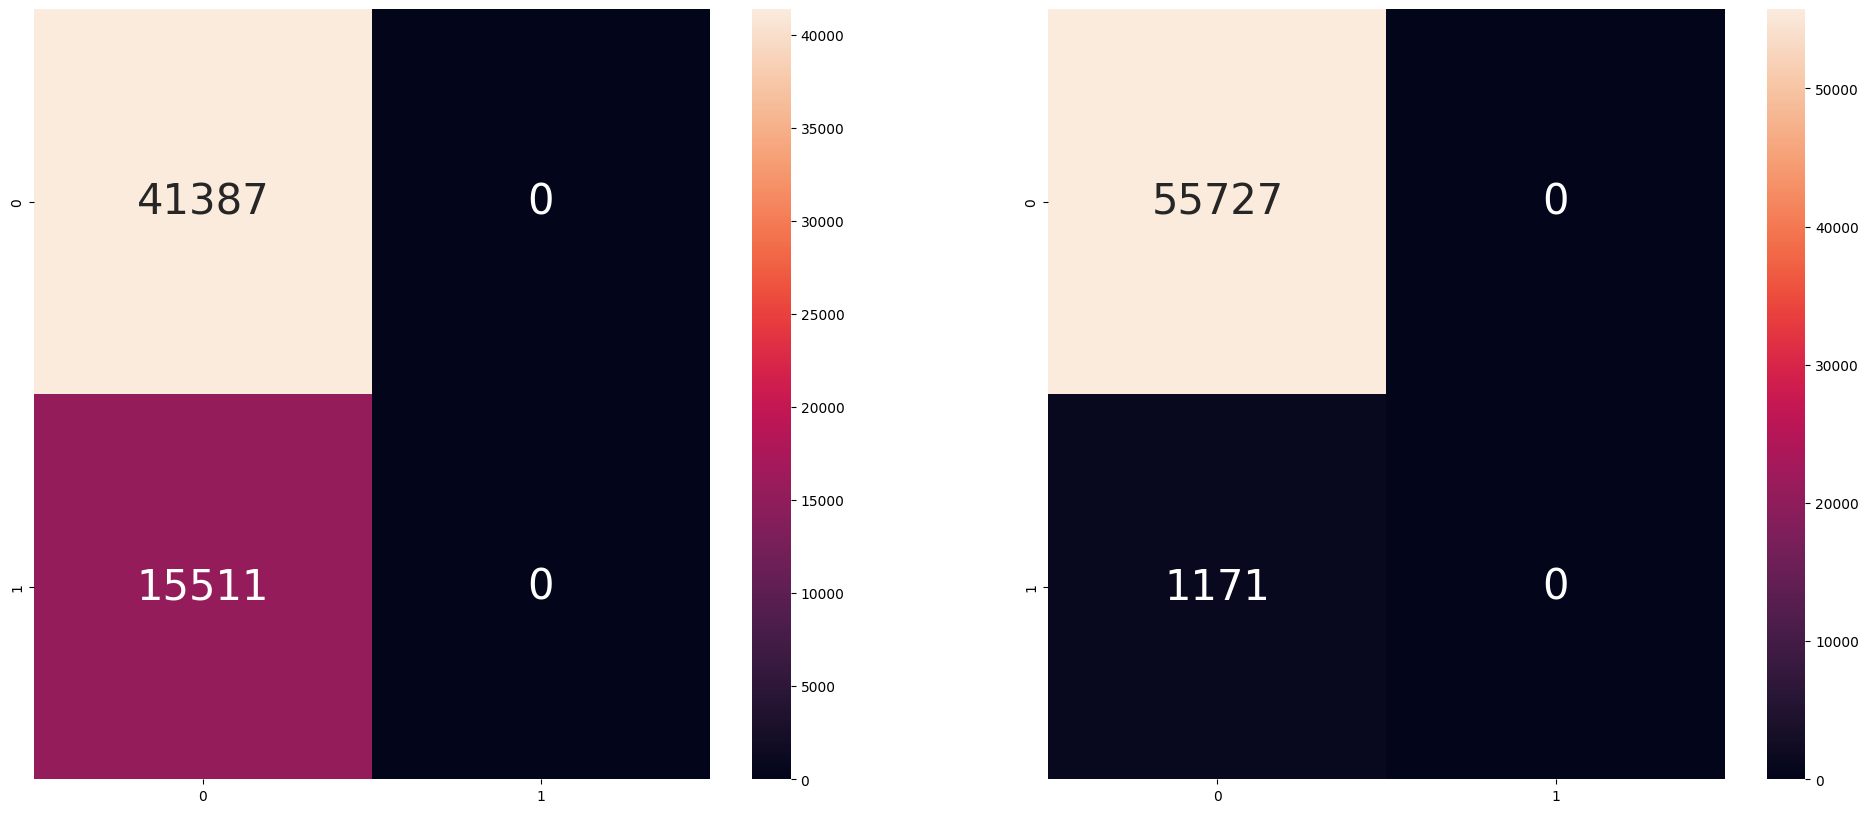

LOGISTIC_REGRESSION
ROC AUC score for premium_user_numerical: 0.5176517792386719
ROC AUC score for will_buy_premium_next_month_numerical: 0.5


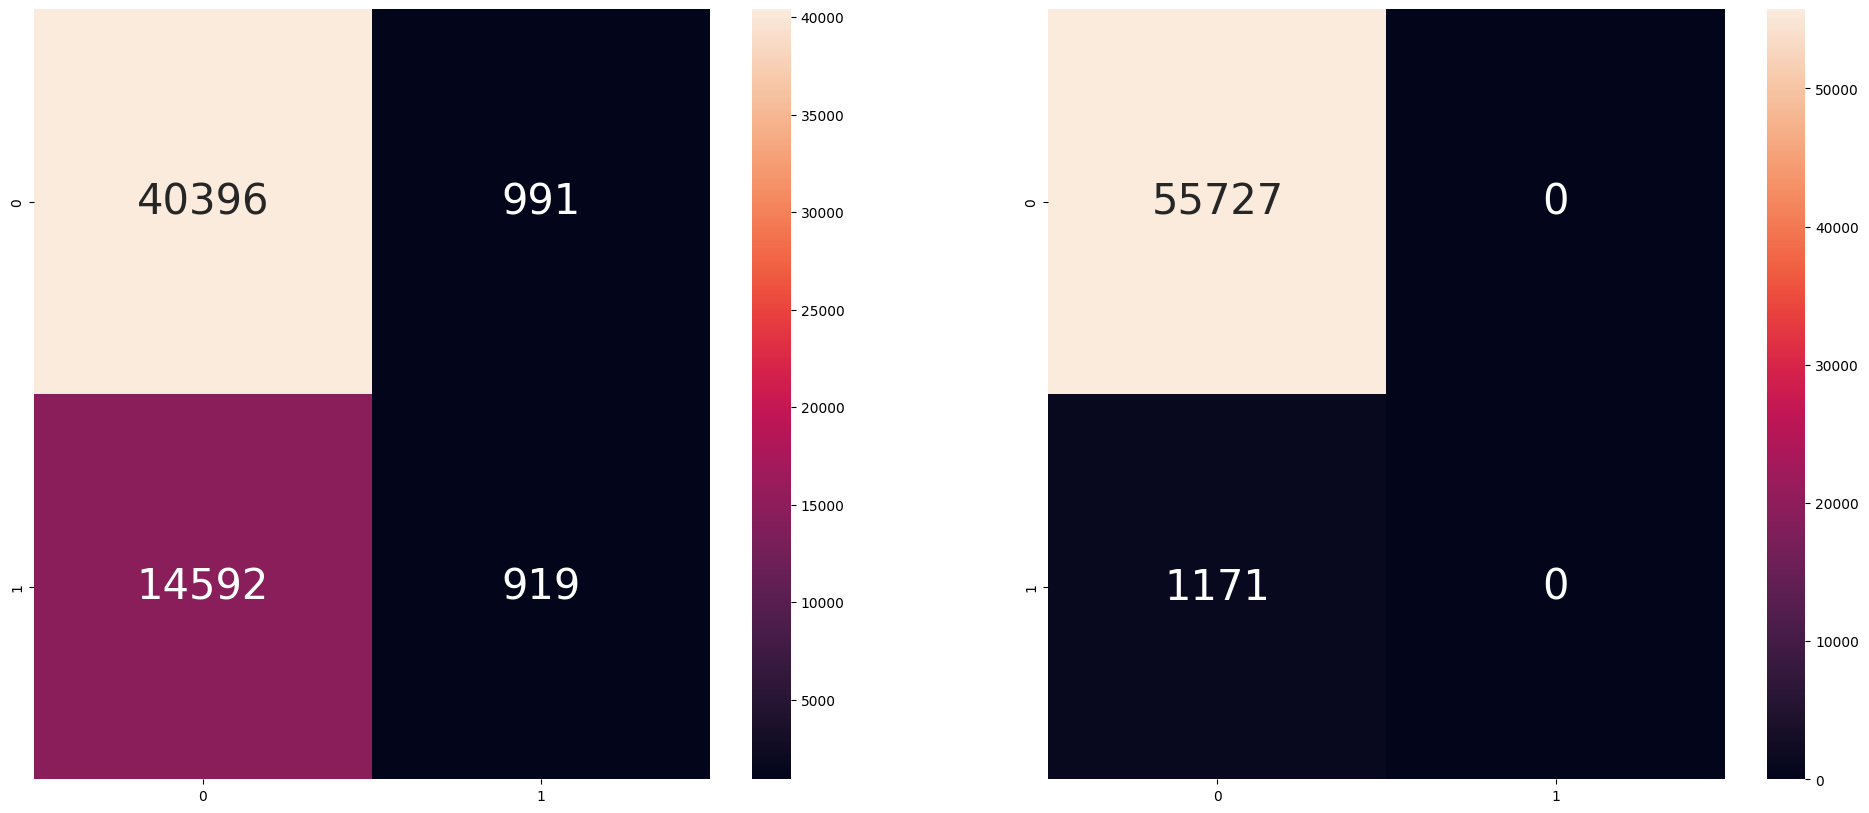

XGB_CLASSIFIER
ROC AUC score for premium_user_numerical: 0.5348136065196359
ROC AUC score for will_buy_premium_next_month_numerical: 0.5073627354727973


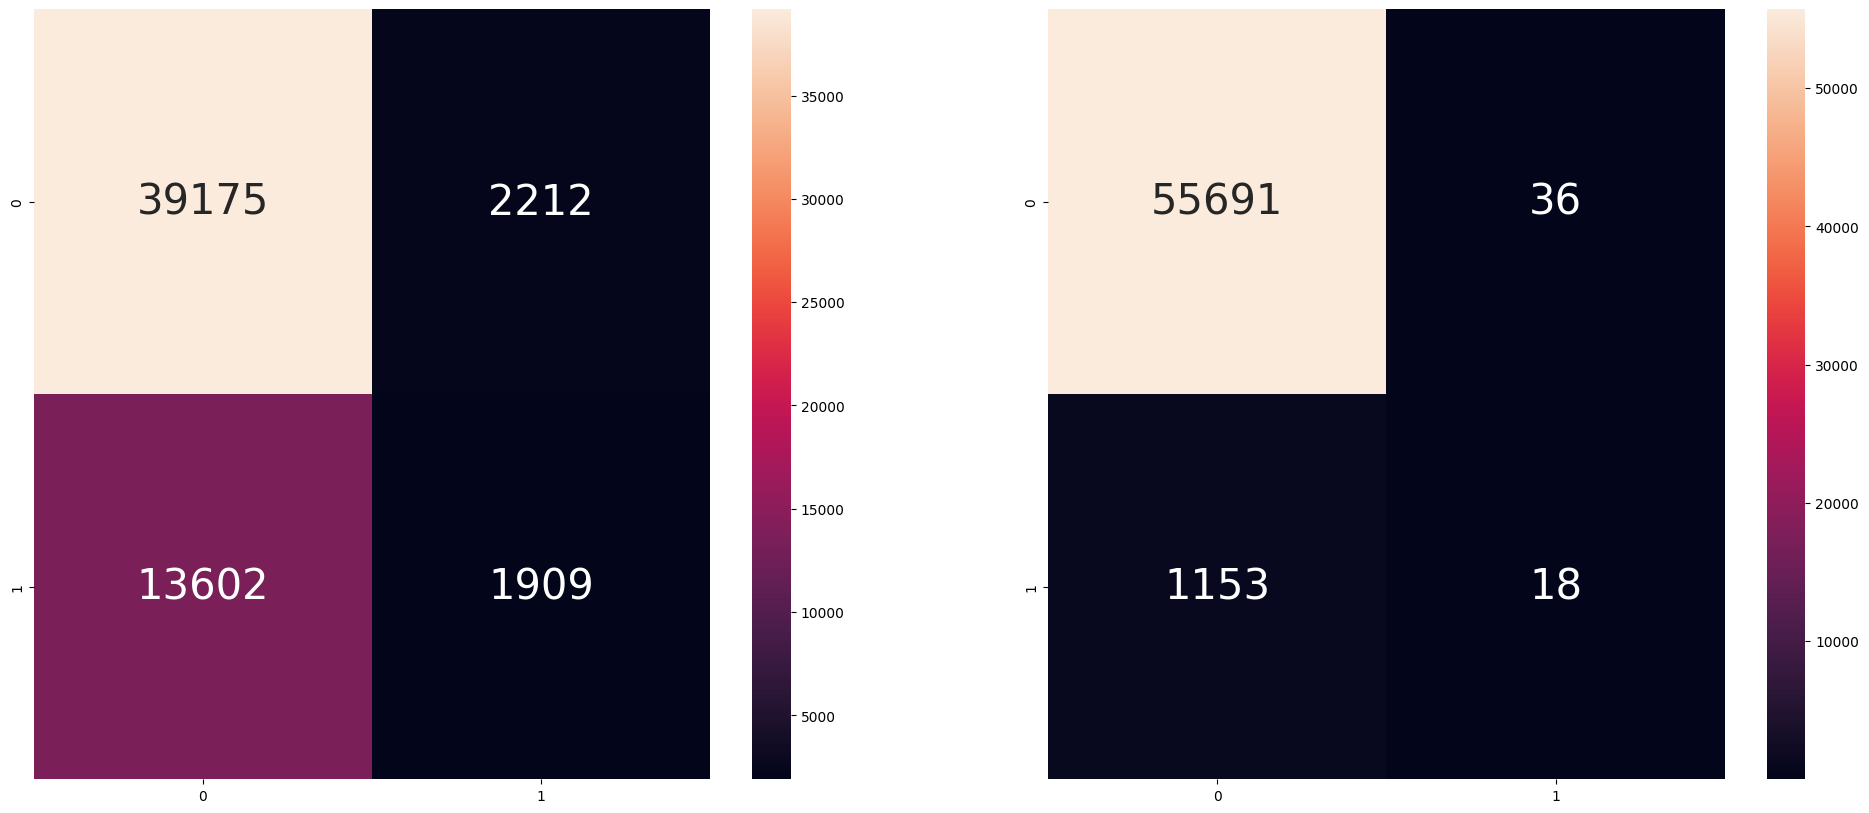

XGB_CLASSIFIER_BEST_ESTIMATOR
ROC AUC score for premium_user_numerical: 0.6704470638373412
ROC AUC score for will_buy_premium_next_month_numerical: 0.6629884276184326


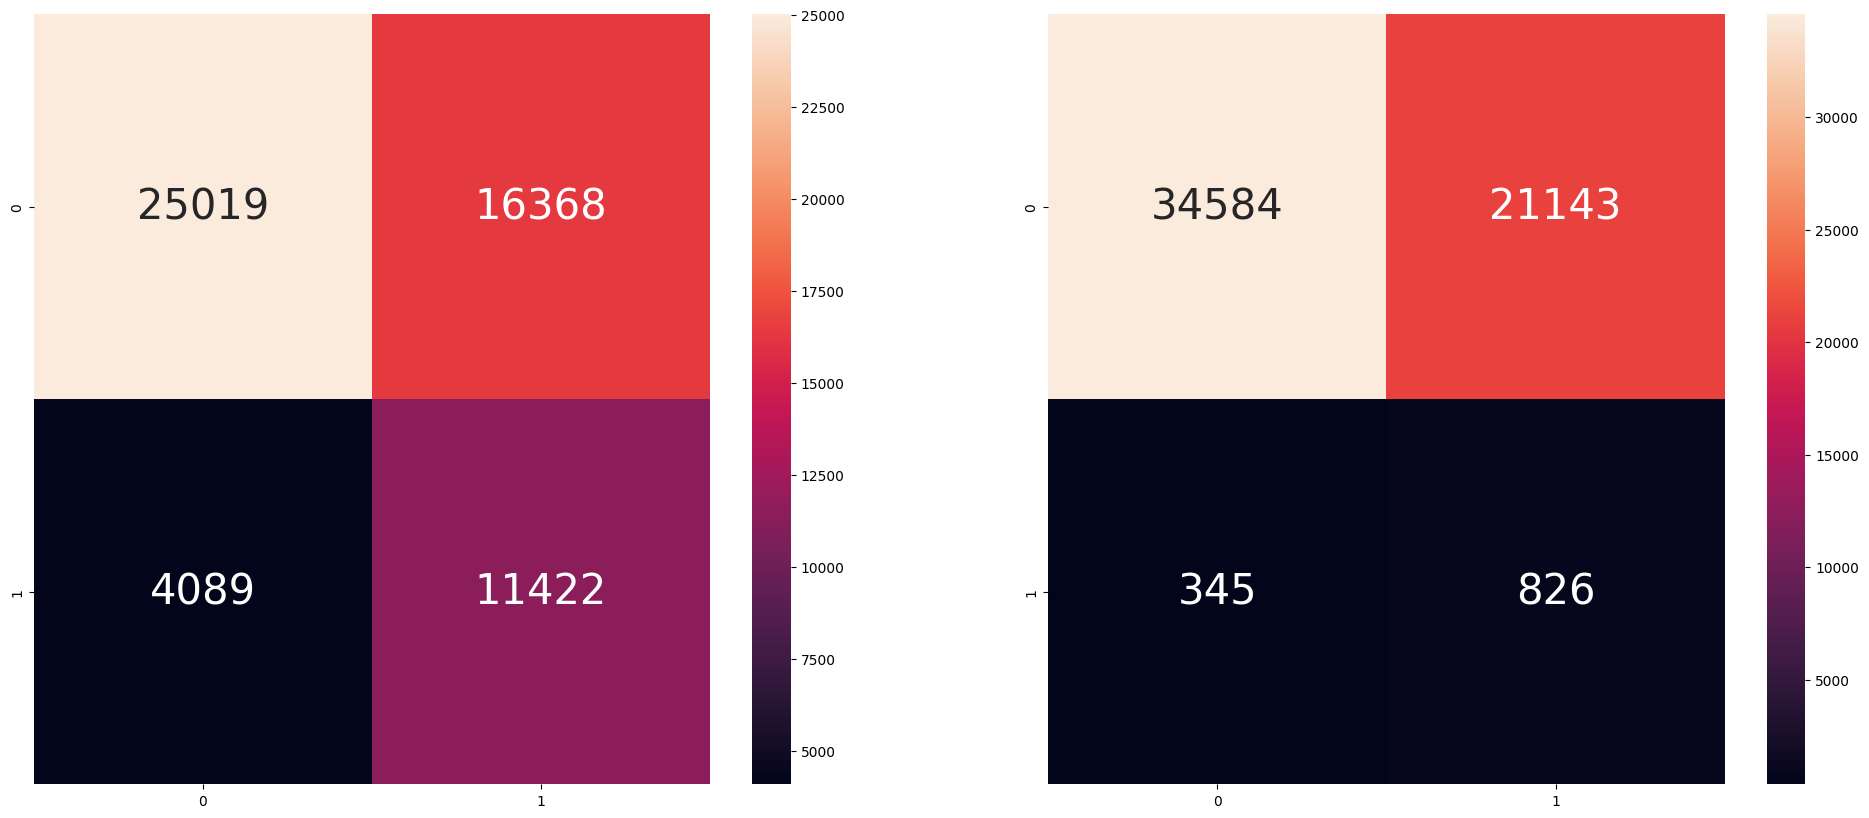

In [13]:
for type in MODEL_TYPES:
    print(type.upper())
    models = MODELS[type]
    plot_confusion_matrix(models, X_test, Y_test)

Analizując wyniki możemy zauważyć, że dla przewidywania `premium_user_numerical` (czy użytkownik kiedykolwiek zakupi premium) najgorzej poradził sobie model naiwny `Dummy`, który każdemu przypisuje klasę większościową. Nieznacznie lepsze wyniki na podobnym poziomie, osiągnęły modele `Logistic Regression` oraz `XGB Classifier`. Najlepsze wyniki osiągnął model `XGB Classifier with Randomized Search`, dzięki optymalizacji hiperparametrów. W przypadku `will_buy_premium_next_month_numerical` (czy użytkownik kupi premium w przeciągu miesiąca) modele `Dummy` oraz `Logistic Regression` w każdym przypadku przewidywały klasę większościową. Model `XGB Classifier` był nieznacznie lepszy. Jedynie model `XGB Classifier with Randomized Search` osiągnął lepszy wynik 0.69, jednak kosztem przypisania większej ilości błędnych predykcji w przypadku klasy większościowej.

### Istotność parametrów

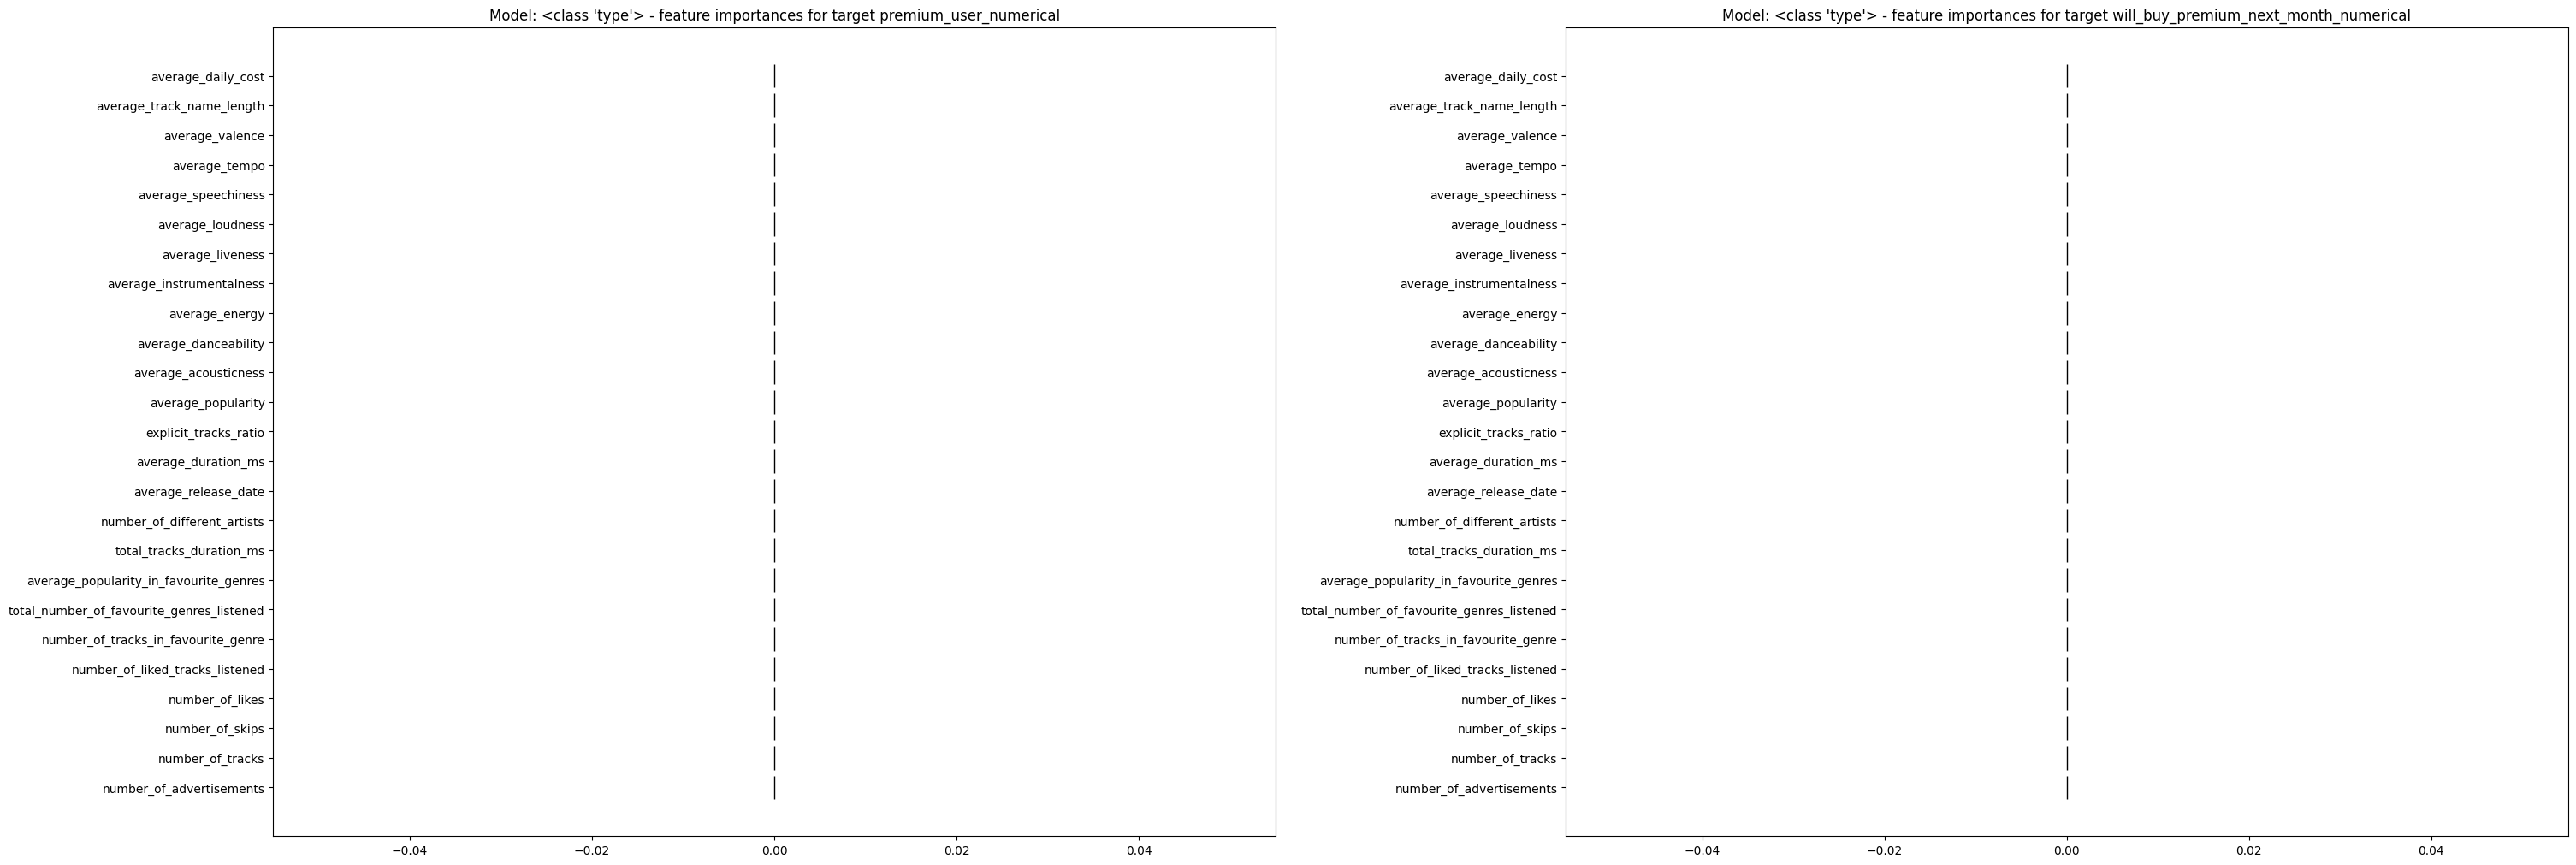

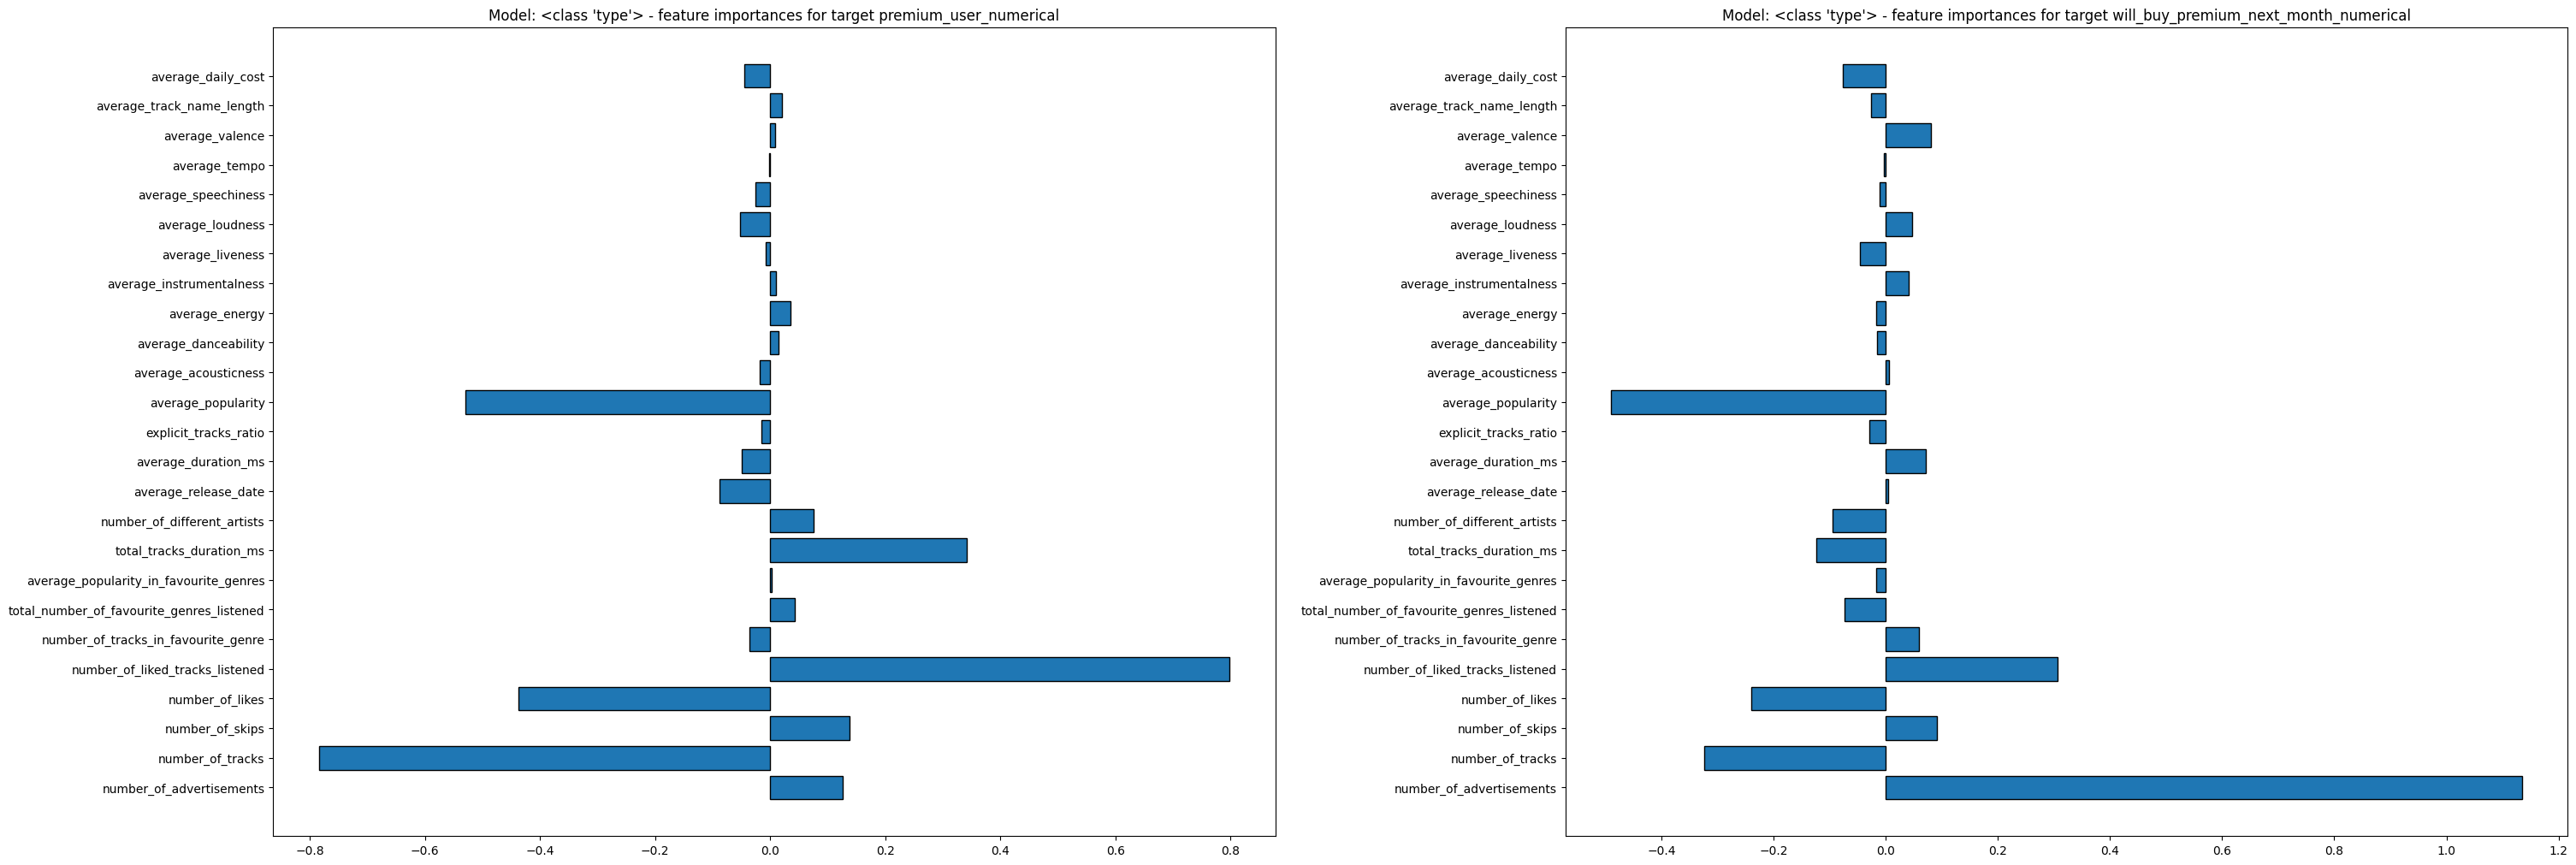

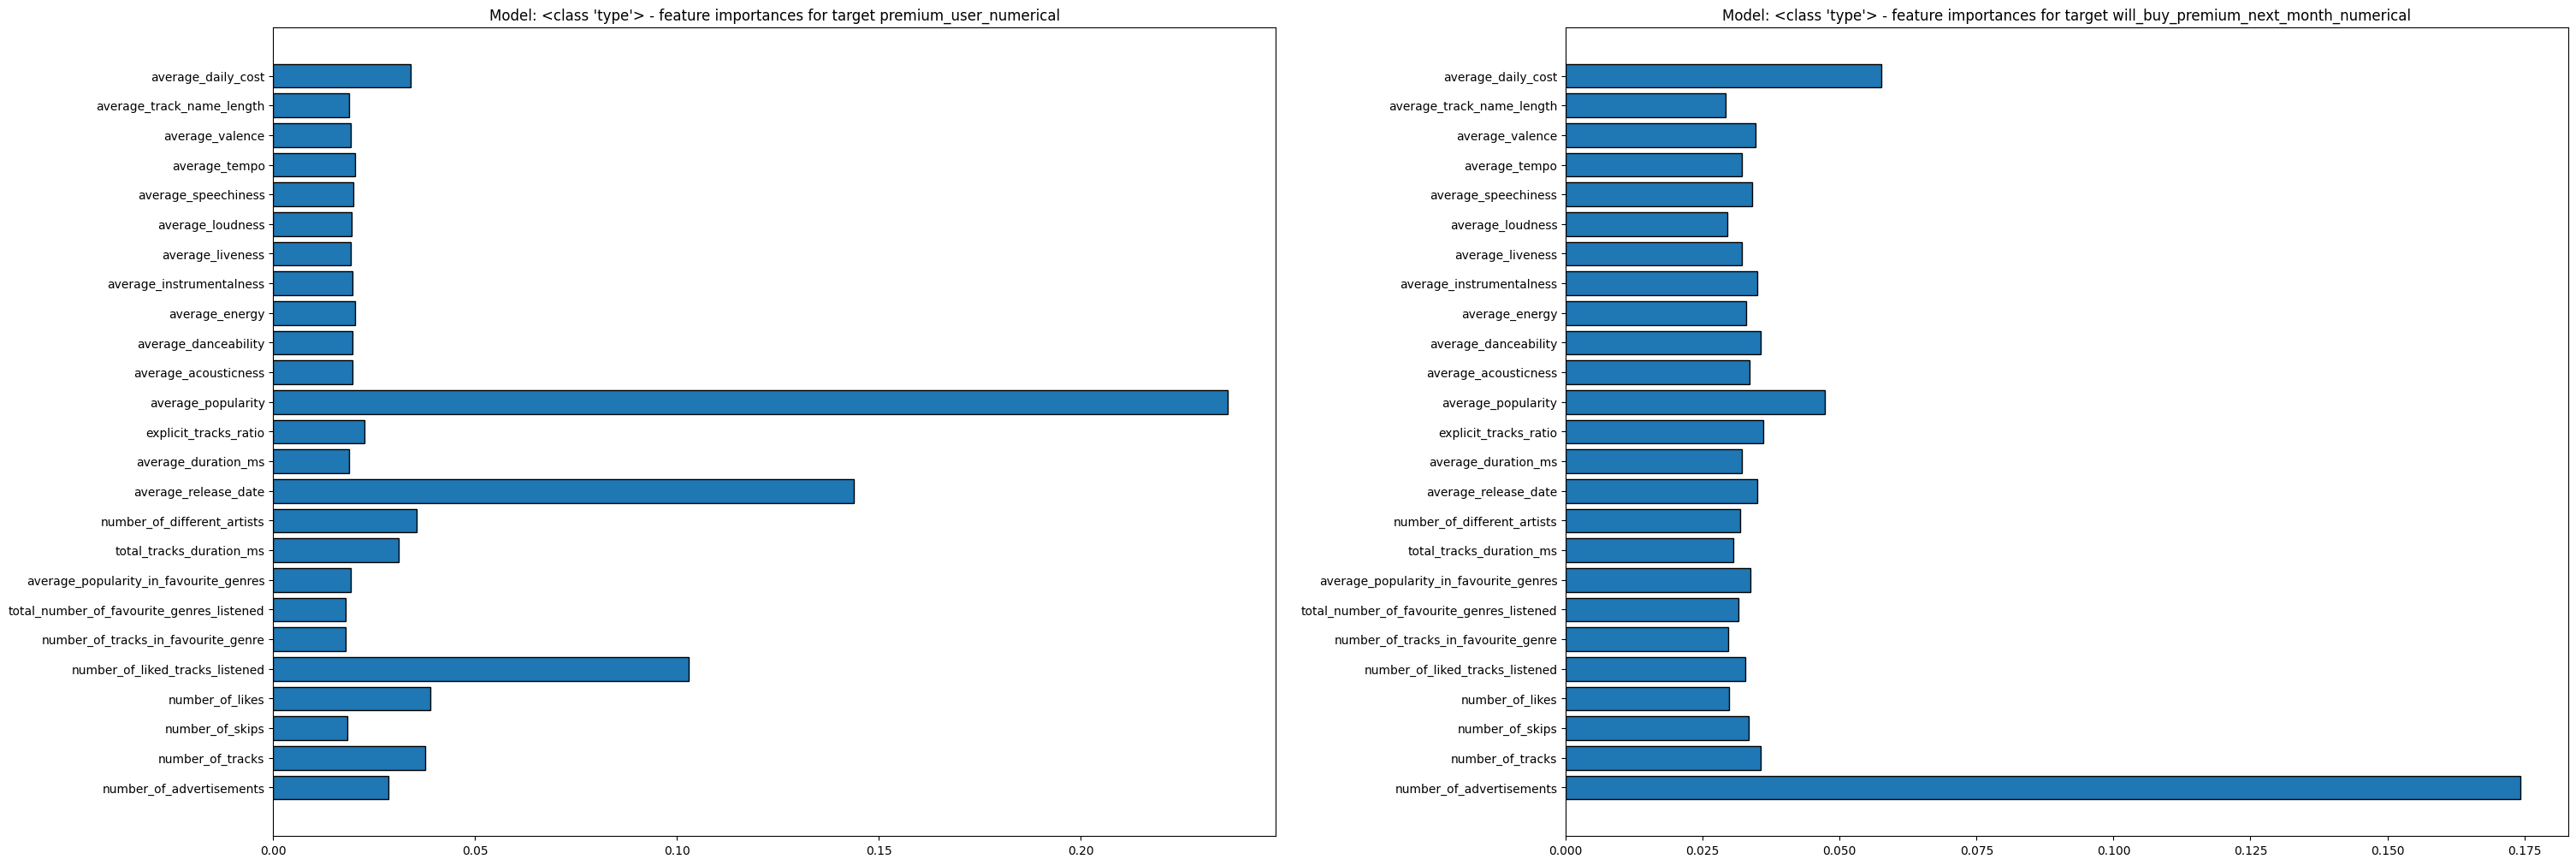

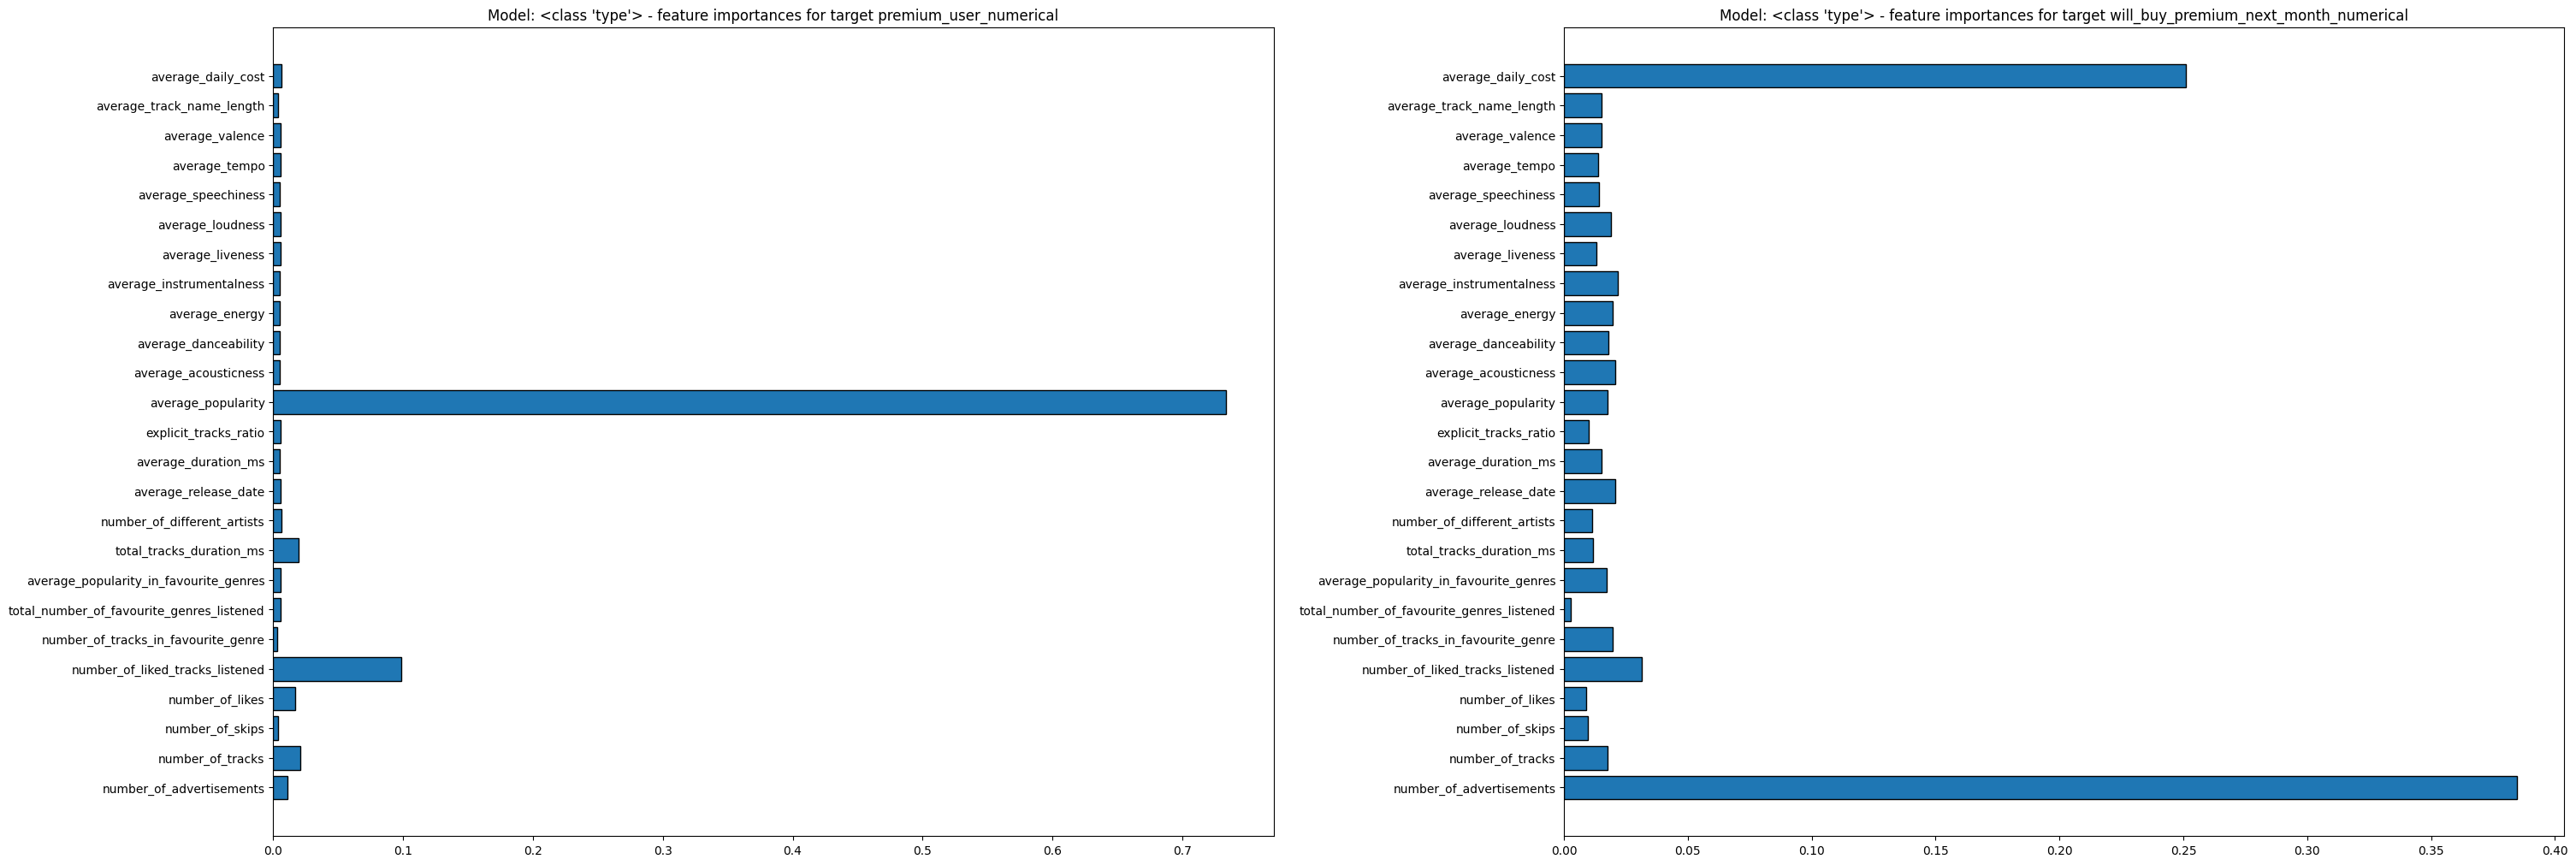

In [14]:
for type in MODEL_TYPES:
    models = MODELS[type]
    plot_feature_importances(models)

Analizując ważność parametrów możemy zauważyć, że większość parametrów jest brana pod uwagę przez modele, jednakże kilka z nich wyróżnia się na tle pozostałych. W przypadku przewidywania dla tego, czy użytkownik zakupi premium w przeciągu miesiąca najważniejszym parametrem jest `number_of_advertisements`, czyli liczba wyświetlanych reklam. Dodatkowo ostatni wytrenowany model uwzględnia jeszcze `average_release_date` oraz `average_daily_cost`. Możemy z tego wnioskować, że aby użytkownik jak najszybciej zakupił premium powinniśmy manipulować ilością wyświetlanych mu reklam. Natomiast w przypadku przewidywania tego, czy użytkownik kiedykolwiek zakupi premium ważniejsze okazuje się `average_popularity` oraz `number_of_licked_tracks_listened` co oznacza, że użytkownicy, którzy słuchają popularniejszych utworów oraz słuchają polubionych utworów są bardziej skłonni do zakupu premium. Może oznaczać, to, że w długofalowej perspektywie ważniejsze może być proponowanie użytkownikowi utworów, które są popularne oraz utworów, które użytkownik polubił, niż wyświetlanie reklam. 

### Eksperymenty A/B
Trenujemy wszystkie modele na danych do 2023, a wyniki dla wszystkich modeli zapisujemy do plików pkl. Uruchamiamy mikroserwis, który wczytuje te modele. Następnie dane użytkowników korzystających w roku 2023 dzielimy na różne rzeczywistości i dla każdej z tych grup wykonujemy predykcję z wykorzystaniem naszego mikroserwisu, a następnie przeprowadzamy porównanie za pomocą testu t-studenta.

In [15]:
X_train = pd.DataFrame(
    pipeline.fit_transform(TRAIN_DATA[FEATURES]),
    columns=FEATURES
)
Y_train = TRAIN_DATA[TARGETS]
for type in MODEL_TYPES:
    estimators = {}
    for target in TARGETS:
        y_train = Y_train[target]
        estimators[target] = MODEL_CONSTRUCTORS[type](
            X_train, y_train, get_params(MODELS[type][target])
        )
    model = IUMModel(pipeline, estimators)
    with open(f'models/{type}.pkl', 'wb') as f:
        pickle.dump(model, f)

In [16]:
np.random.seed(RANDOM_SEED)

random_ordered_ids = np.random.permutation(
    TEST_DATA['user_id'].unique()  # type: ignore
)
size = len(random_ordered_ids) // len(MODEL_TYPES)

REALITIES: Dict[str, pd.DataFrame] = {}

for i, type in enumerate(MODEL_TYPES):
    ids = random_ordered_ids[i * size:(i + 1) * size]
    mask = TEST_DATA['user_id'].isin(ids)
    REALITIES[type] = TEST_DATA.loc[mask]

In [17]:
for type in MODEL_TYPES:
    display(REALITIES[type].head())

,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
378,14848,2023,3,1,1,0,15,36,2,5,...,0.648306,0.512556,0.027164,0.155794,-7.668833,0.087006,106.619583,0.463817,13.333333,0.023180
2129,5945,2023,1,1,1,1,17,32,0,9,...,0.654094,0.547312,0.045521,0.120609,-7.680031,0.067134,111.153844,0.473512,12.312500,0.023636
2378,9065,2023,3,1,1,0,11,36,0,8,...,0.678528,0.589583,0.030580,0.149925,-6.894583,0.083008,114.375944,0.515417,14.194444,0.022362
2836,17778,2023,1,1,1,0,9,32,1,10,...,0.616688,0.566781,0.097120,0.207247,-7.540094,0.089953,113.637219,0.393766,12.125000,0.024966
2905,8001,2023,1,1,1,0,14,37,19,4,...,0.440108,0.691568,0.107200,0.302508,-9.375378,0.073959,117.028243,0.418997,24.783784,0.014111


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
328,7643,2023,1,1,0,0,10,26,11,11,...,0.481962,0.644192,0.122086,0.228292,-9.241962,0.066550,125.406462,0.468627,25.692308,0.013864
331,7643,2023,1,1,0,0,7,26,14,9,...,0.499385,0.719962,0.071406,0.198385,-8.612577,0.056546,124.025731,0.591512,22.192308,0.012140
443,18214,2023,1,1,1,0,4,16,9,3,...,0.480187,0.652187,0.045305,0.223931,-9.035750,0.043562,115.447125,0.474750,24.375000,0.014265
457,18501,2023,1,1,1,0,13,28,13,10,...,0.478964,0.671143,0.065366,0.224946,-8.977607,0.057068,127.819821,0.572821,21.571429,0.012536
3385,15047,2023,1,1,1,1,14,39,19,14,...,0.487282,0.719385,0.127397,0.201549,-8.873872,0.063238,125.130744,0.527464,23.615385,0.012737


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
942,11621,2023,3,1,1,1,15,37,1,5,...,0.666946,0.577703,0.015345,0.137381,-6.718757,0.084957,108.457351,0.506541,13.189189,0.023551
949,11621,2023,1,1,0,0,13,36,2,8,...,0.667389,0.615833,0.029088,0.171839,-6.333861,0.090872,115.756556,0.561761,13.583333,0.023168
3957,1683,2023,3,0,0,0,5,23,2,6,...,0.641652,0.596652,0.080146,0.177004,-6.761391,0.079122,109.921217,0.525174,14.260870,0.023007
3958,1683,2023,1,0,0,0,5,11,0,5,...,0.671818,0.637909,0.024495,0.173245,-5.576636,0.123464,101.576636,0.494727,11.545455,0.020181
4082,7587,2023,2,0,0,0,6,21,11,7,...,0.510905,0.700714,0.085120,0.341138,-9.038524,0.058895,118.139429,0.515286,22.142857,0.013414


,user_id,year,month,premium_user_numerical,will_buy_premium_next_month_numerical,number_of_premium,number_of_advertisements,number_of_tracks,number_of_skips,number_of_likes,...,average_danceability,average_energy,average_instrumentalness,average_liveness,average_loudness,average_speechiness,average_tempo,average_valence,average_track_name_length,average_daily_cost
41,4074,2023,3,1,1,0,1,6,0,2,...,0.626167,0.560333,0.005269,0.148200,-6.978667,0.128867,134.761333,0.527667,7.333333,0.019577
47,4074,2023,1,1,0,0,13,37,3,9,...,0.673216,0.623946,0.022808,0.185284,-6.816027,0.093181,115.215946,0.511486,11.405405,0.026657
474,1944,2023,1,1,1,0,7,27,13,10,...,0.505333,0.657370,0.132346,0.151230,-9.610593,0.081237,129.688852,0.569074,19.925926,0.011697
483,1944,2023,1,1,1,0,5,13,7,7,...,0.488308,0.625231,0.189436,0.269831,-9.640538,0.051131,125.086231,0.607846,31.461538,0.012755
2611,15895,2023,3,1,1,0,2,5,3,2,...,0.513200,0.439800,0.025822,0.216700,-12.256600,0.040380,129.347000,0.483400,34.600000,0.011271


In [18]:
result = SERVICE_PREDICTION_MODEL_INIT

for type in MODEL_TYPES:
    url = f'http://127.0.0.1:5000/predict/{type}'

    for i in range(0, len(TEST_DATA)):
        row = TEST_DATA.iloc[i].to_dict()

        response = requests.post(url, json=row).json()  # type: ignore

        for target in TARGETS:
            current = pd.DataFrame({
                "guess": [1 if response[target] else 0],
                "ground_truth": [row[target]],
                "model": [type],
                "year": [row['year']],
                "month": [row['month']],
                "user_id": [row['user_id']],
            })

            result[type][target] = pd.concat(
                [result[type][target], current], ignore_index=True
            )

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /predict/dummy (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fca7582c250>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
for type in MODEL_TYPES:
    print(type.upper())
    for target in TARGETS:
        print(target)
        print()
        print(result[type][target].guess.value_counts())
        print()
        print(result[type][target].ground_truth.value_counts())
        roc_auc_score_value = roc_auc_score(
            result[type][target].ground_truth, result[type][target].guess
        )
        print()
        print('ROC AUC score = ', roc_auc_score_value)
        print()

In [ ]:
for type in MODEL_TYPES:
    for target in TARGETS:
        result[type][target].to_csv(f'ab_experiment/{type}-{target}.csv')

Ustalamy hipotezę zerową $H_0$ mówiącą, że pierwszy model nie jest lepszy od drugiego oraz hipotezę alternatywną $H_1$ głoszącą, że model pierwszy jest lepszy od modelu drugiego.

Na podstawie tabeli rozkładu t-studenta, przyjętego istotności statystycznej jako $0.05$ oraz stopni swobody $12 + 12 - 2 = 22$ ustaliliśmy wartość parametru $t_\alpha$ jako $2.074$

$$
t = \frac{\overline{q}_A - \overline{q}_B}{s_p  \sqrt{\frac{1}{n_A} + \frac{1}{n_B}}}
$$

$$
s_p = \sqrt{\frac{(n_A - 1) \sigma^2 + (n_B - 1) \sigma^2}{n_A + n_B - 2}}
$$

In [ ]:
BUCKETS = 12
T_ALPHA = 2.074


def s_p(sigma_A: float, sigma_B: float) -> float:
    return sqrt(
        (BUCKETS - 1) * (sigma_A ** 2) + (BUCKETS - 1) * (sigma_B ** 2)
        / (BUCKETS + BUCKETS - 2)
    )


def t(q_A: float, q_B: float, s_p_value: float) -> float:
    return (q_A - q_B) / (s_p_value * sqrt(1 / BUCKETS + 1 / BUCKETS))

In [ ]:
np.random.seed(RANDOM_SEED)

for type_A, type_B in itertools.product(MODEL_TYPES, MODEL_TYPES):
    if type_A == type_B:
        continue
    print(f'{type_A} vs {type_B}'.upper())
    print()
    for target in TARGETS:
        print(target)
        reality_A: pd.DataFrame = result[type_A][target]
        reality_B: pd.DataFrame = result[type_B][target]

        data = pd.concat([reality_A, reality_B])
        random_ordered_ids = np.random.permutation(
            data['user_id'].unique()
        )
        size = len(random_ordered_ids) // BUCKETS

        reality_A_score = []
        reality_B_score = []

        for bucket in range(BUCKETS):
            ids = random_ordered_ids[bucket * size:(i + 1) * size]
            mask = data['user_id'].isin(ids)
            bucket_data = data.loc[mask]
            reality_A_data = bucket_data.loc[bucket_data['model'] == type_A]
            reality_B_data = bucket_data.loc[bucket_data['model'] == type_B]

            reality_A_score.append(
                roc_auc_score(
                    reality_A_data['ground_truth'],
                    reality_A_data['guess'],
                )
            )
            reality_B_score.append(
                roc_auc_score(
                    reality_B_data['ground_truth'],
                    reality_B_data['guess']
                )
            )

        s_p_value = s_p(stdev(reality_A_score), stdev(reality_B_score))
        if s_p_value != 0:
            t_value = t(mean(reality_A_score), mean(
                reality_B_score), s_p_value)
        else:
            t_value = 0

        if t_value > T_ALPHA:
            print(f'{type_A} is better than {type_B}')
        else:
            print(f'We can\'t say that {type_A} is better than {type_B}')
        print()

Z przeprowadzonego eksperymentu wynika, że model `XGB Classifier with Randomized Search` jest lepszy od reszty modeli w przewidywaniu wartości `will_buy_premium_next_month_numerical` oraz jest lepszy od modelu naiwnego `Dummy` w przypadku przewidywania wartości `premium_user_numerical`.